# Advanced RAG Architectures: Implementation and Evaluation

## Learning Outcomes

By the end of this notebook, you'll be able to:
- Understand and implement three advanced RAG architectures (Simple RAG, CRAG, and Adaptive RAG)
- Apply RAGAS evaluation metrics to assess RAG performance
- Analyze and visualize evaluation results using customized dashboards
- Select the most appropriate RAG architecture for specific use cases

## Setup and Required Libraries

In [ ]:
# Import necessary libraries
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple, TypedDict, Optional, Callable, Union

# RAG and LLM libraries
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Vector stores and embedding models
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from chromadb.config import Settings

# LLM models
from langchain_openai import ChatOpenAI

# Tool libraries
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph components for advanced RAG
from langgraph.graph import StateGraph, END

# RAGAS evaluation
from datasets import load_dataset
from ragas import evaluate, EvaluationDataset
from ragas.metrics import (
    Faithfulness,
    ContextRelevance,
    ContextPrecision,
    ContextRecall,
    AnswerRelevancy,
    AnswerCorrectness
)
from ragas.llms import LangchainLLMWrapper

# Set environment variables - replace with your actual keys
# os.environ["OPENAI_API_KEY"]
# os.environ["TAVILY_API_KEY"]
print("Libraries imported successfully!")

OpenAI API key set successfully
Tavily API key set successfully
Libraries imported successfully!


## 1. Introduction to Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) represents a significant advancement in the field of artificial intelligence, particularly for applications requiring factual accuracy and knowledge-intensive tasks. RAG combines the strengths of both retrieval-based and generative approaches to create systems that can access external knowledge while maintaining the flexibility of large language models (LLMs).

### What is RAG?

RAG is a framework that enhances LLMs with the ability to retrieve relevant information from external sources before generating responses. This approach addresses one of the key limitations of traditional LLMs - their tendency to hallucinate or generate plausible-sounding but incorrect information when operating solely on their parametric knowledge.

![RAG Architecture](https://miro.medium.com/v2/resize:fit:1400/1*iUHvLG0QIsYwUZ2AG7SGVg.png)

### Why RAG Matters

RAG systems offer several critical advantages:

1. **Improved Factual Accuracy**: By grounding responses in retrieved documents, RAG reduces hallucinations and factual errors.

2. **Knowledge Recency**: RAG can access up-to-date information beyond the LLM's training cutoff.

3. **Sourcing and Attribution**: Retrieved passages provide citation sources for generated content.

4. **Domain Adaptation**: Organizations can connect LLMs to their proprietary knowledge bases, creating specialized assistants without expensive fine-tuning.

### Basic RAG Architecture

A standard RAG system consists of these core components:

1. **Document Collection**: The corpus of knowledge from which information will be retrieved

2. **Document Processing**: Converting documents into a suitable format for retrieval, typically involving chunking and embedding

3. **Retriever**: The component that finds relevant information based on a query

4. **Generator**: Usually an LLM that creates a response using the retrieved information

5. **Orchestration Layer**: Manages the flow between components, including prompt construction

However, as we'll explore in this notebook, advanced RAG architectures introduce additional capabilities and feedback loops to enhance performance on complex tasks.

### Why RAG Systems Need Evaluation

Despite their advantages, RAG systems introduce new complexities and potential failure points. Effective evaluation is essential to:

- Identify when retrieval provides irrelevant or misleading context
- Detect when the generator ignores retrieved information (over-relies on parametric knowledge)
- Measure whether the generated response accurately reflects the retrieved context
- Assess if the final answer fulfills the user's information need

In this notebook, we'll explore three increasingly sophisticated RAG architectures - Simple RAG, Corrective RAG (CRAG), and Adaptive RAG - and systematically evaluate them using the RAGAS framework to identify the most effective approach.

## 2. Advanced RAG Architectures

As RAG systems have evolved, researchers and practitioners have developed increasingly sophisticated architectures to address the limitations of basic RAG implementations. In this section, we'll explore three of these architectures: Simple RAG (our baseline), Corrective RAG (CRAG), and Adaptive RAG.

### 2.1 Simple RAG

Simple RAG represents the most straightforward implementation of Retrieval-Augmented Generation. It follows a linear pipeline with these key steps:

1. **Query Processing**: The user's query is received and processed
2. **Retrieval**: The query is used to retrieve relevant documents from a vector store
3. **Context Integration**: Retrieved documents are combined with the user query in a prompt
4. **Generation**: An LLM generates a response based on the context-enhanced prompt

![Simple RAG Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*9g8Ypf6GYK5AKqc-GbBWMg.png)

This straightforward architecture works well for many applications, particularly when:
- The document collection is high-quality and well-structured
- Queries are clear and unambiguous
- The retrieval process consistently finds relevant documents

**Limitations of Simple RAG:**
- No mechanism to validate the quality of retrieved documents
- Unable to adapt when retrieval fails to find relevant information
- Cannot handle queries requiring multiple retrieval steps
- Lacks self-correction capabilities

### 2.2 Corrective RAG (CRAG)

Corrective RAG (CRAG) addresses a critical limitation of Simple RAG: what happens when retrieval produces irrelevant or insufficient results? Introduced in a paper by Liu et al. (2024), CRAG adds a self-assessment loop to the RAG pipeline.

![CRAG Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*RrSOSLMRJFB8YWRe96fQ5A.jpeg)

The CRAG workflow includes these key innovations:

1. **Document Grading**: After retrieval, each document is evaluated for relevance to the query
2. **Knowledge Refinement**: Retrieved documents can be broken into smaller "knowledge strips" and filtered
3. **Retrieval Fallback**: If no relevant documents are found, or if the grader is unsure, the system can trigger alternate information sources (like web search)
4. **Query Transformation**: Before fallback retrieval, the query may be rewritten to improve search results

CRAG's self-correcting mechanism makes it more robust in scenarios where the initial retrieval might fail, ensuring that the generated response is grounded in relevant information.

### 2.3 Adaptive RAG

Adaptive RAG takes system sophistication a step further by dynamically routing queries through different processing paths based on an analysis of the query itself. This architecture allows for efficient resource usage and optimization for different query types.

![Adaptive RAG Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*KSyavRDHFOGWEmpgbqy3tA.png)

Key components of Adaptive RAG include:

1. **Query Classifier**: Analyzes the query to determine its complexity and type, then routes it to the appropriate processing path

2. **Multiple Processing Paths** which may include:
   - **Direct LLM Generation**: For simple queries that don't need external information
   - **Simple Retrieval**: For straightforward factual queries
   - **Multi-hop Retrieval**: For complex queries requiring information synthesis across documents
   - **External Knowledge Sources**: For current events or specialized information

3. **Path Selection Logic**: Rules or models that determine which path is most appropriate for each query

Adaptive RAG offers several advantages:
- **Efficiency**: Simple queries bypass unnecessary retrieval steps
- **Flexibility**: Different query types receive specialized handling
- **Resource Optimization**: Expensive operations are only used when needed
- **Improved Performance**: Each query type is processed using the most effective approach

In the implementation section, we'll build working examples of each of these architectures and evaluate their performance using the RAGAS framework.

## 3. Evaluation Metrics and RAGAS

Evaluation is a crucial aspect of developing effective RAG systems. Without proper metrics, it's challenging to identify areas for improvement or compare different implementation strategies. RAGAS (Retrieval Augmented Generation Assessment) is a framework specifically designed for comprehensive evaluation of RAG systems.

### 3.1 Understanding RAGAS

RAGAS provides a suite of metrics that evaluate different aspects of a RAG system's performance. It uses LLM-based assessment techniques to provide a more nuanced evaluation than traditional metrics.

![RAGAS Framework](https://miro.medium.com/v2/resize:fit:1400/1*qhbK_-pfF8TGECIrJi9nvQ.png)

### 3.2 Key RAGAS Metrics

Ragas evaluates RAG systems across several dimensions:

#### 3.2.1 Faithfulness

Faithfulness measures whether the generated response contains only information that can be derived from the retrieved documents. It detects hallucinations and unsupported statements.

**Mathematical Definition:**

$\text{Faithfulness} = \frac{\text{Number of claims in response supported by retrieved context}}{\text{Total number of claims in response}}$

A score of 1 indicates perfect faithfulness (all claims are supported), while 0 indicates complete fabrication.

**Example:**

- **Question**: "When was Albert Einstein born?"
- **Retrieved Context**: "Albert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist."
- **Response**: "Albert Einstein was born on March 14, 1879, in Germany."
- **Faithfulness Score**: 1.0 (all claims are supported by the context)

#### 3.2.2 Context Precision

Context Precision evaluates whether the retrieved documents are relevant to the question being asked. It measures the proportion of retrieved context that is actually useful for answering the query.

**Mathematical Definition:**

$\text{Context Precision} = \frac{\text{Number of relevant chunks retrieved}}{\text{Total number of chunks retrieved}}$

Higher scores indicate more precise retrieval with less irrelevant information.

**Example:**

- **Question**: "What are Einstein's contributions to physics?"
- **Retrieved Contexts**: ["Einstein's theory of relativity revolutionized physics.", "Einstein won the Nobel Prize for his work on the photoelectric effect.", "The weather in Berlin today is sunny."]
- **Context Precision Score**: 0.67 (2 out of 3 chunks are relevant)

#### 3.2.3 Context Recall

Context Recall measures whether all the information needed to answer the question is present in the retrieved documents. It assesses if important information is missing from the retrieved context.

**Mathematical Definition:**

$\text{Context Recall} = \frac{\text{Number of claims in reference answer supported by retrieved context}}{\text{Total number of claims in reference answer}}$

Higher scores indicate that the retrieval system is finding most or all of the needed information.

**Example:**

- **Question**: "List Einstein's major achievements."
- **Reference Answer**: "Einstein's major achievements include the theory of relativity, explaining the photoelectric effect, and his work on Brownian motion."
- **Retrieved Context**: "Einstein developed the theory of relativity and explained the photoelectric effect."
- **Context Recall Score**: 0.67 (2 out of 3 achievements are covered)

#### 3.2.4 Answer Relevancy

Answer Relevancy evaluates how well the generated response addresses the user's question, regardless of whether it's factually correct. It measures if the answer is on-topic and satisfies the information need expressed in the query.

**Mathematical Definition:**

$\text{Answer Relevancy} = \frac{1}{N} \sum_{i=1}^{N} \cos(E_{g_i}, E_o)$

Where:
- $E_{g_i}$ is the embedding of a question that could be answered by the response
- $E_o$ is the embedding of the original question
- $N$ is the number of generated questions (typically 3-5)

**Example:**

- **Question**: "How did Einstein's theories impact modern science?"
- **Response**: "Einstein's theory of relativity fundamentally changed our understanding of space, time, and gravity, leading to numerous technological applications including GPS systems."
- **Answer Relevancy Score**: 0.95 (very relevant to the question asked)

#### 3.2.5 Answer Correctness

Answer Correctness compares the generated answer with a reference (ground truth) answer to assess factual accuracy. It combines semantic similarity with factual overlap.

**Mathematical Definition:**

It's a weighted combination of semantic similarity and factual overlap:

$\text{Answer Correctness} = w_1 \cdot \text{Factual Overlap} + w_2 \cdot \text{Semantic Similarity}$

Where typical weights are $w_1 = 0.75$ and $w_2 = 0.25$.

**Example:**

- **Question**: "What is E=mc²?"
- **Reference Answer**: "E=mc² is Einstein's mass-energy equivalence formula showing that energy (E) equals mass (m) times the speed of light (c) squared."
- **Generated Answer**: "Einstein's famous equation E=mc² demonstrates that mass can be converted to energy, where E is energy, m is mass, and c is the speed of light."
- **Answer Correctness Score**: 0.85 (high factual overlap and semantic similarity)

### 3.3 Combined RAGAS Score

These individual metrics can be combined into an overall RAGAS score to provide a holistic assessment of RAG performance. The combined score is typically an average of the component scores, sometimes with different weights based on the specific requirements of the application.

$\text{RAGAS Score} = \frac{\text{Faithfulness} + \text{Context Precision} + \text{Context Recall} + \text{Answer Relevancy} + \text{Answer Correctness}}{5}$

In the next sections, we'll implement different RAG architectures and evaluate them using these RAGAS metrics to determine which performs best on our dataset.

## 4. Implementation

### 4.1 Data Preparation and Document Processing

In [12]:
# Load and examine the ragas-wikiqa dataset
wiki_dataset = load_dataset("explodinggradients/ragas-wikiqa")
print(f"Number of samples in wiki_dataset: {len(wiki_dataset)}")
print(f"Dataset keys: {wiki_dataset['train']}")

# Let's examine the structure of the dataset
sample = wiki_dataset["train"][0]
print(f"\nSample structure:\n")
for key, value in sample.items():
    if isinstance(value, list) and len(value) > 0:
        print(f"{key}: [list with {len(value)} items]")
        print(f"  First item: {value[0]}")
    else:
        print(f"{key}: {value}")

# Extract questions and contexts to create document collection
questions = [item['question'] for item in wiki_dataset["train"]]
print(f"\nTotal questions: {len(questions)}")
print(f"Example question: {questions[0]}")

# Extract contexts (these will be our documents for RAG)
raw_contexts = [item['context'] for item in wiki_dataset["train"]]

# Convert contexts to Document objects for our RAG system
documents = []
for i, contexts in enumerate(raw_contexts):
    for j, context in enumerate(contexts):
        doc = Document(
            page_content=context,
            metadata={
                "source": f"sample_{i}_context_{j}",
                "question_id": i
            }
        )
        documents.append(doc)

print(f"\nTotal documents extracted: {len(documents)}")
print(f"First document: {documents[0].page_content[:100]}...")

# Create a test set from the dataset for evaluation
evaluation_samples = []
for item in wiki_dataset['train']:
    evaluation_samples.append({
        "user_input": item["question"],
        "reference": item["correct_answer"]
    })

print(f"\nCreated {len(evaluation_samples)} evaluation samples")

Number of samples in wiki_dataset: 1
Dataset keys: Dataset({
    features: ['question', 'correct_answer', 'incorrect_answer', 'question_id', 'generated_with_rag', 'context', 'generated_without_rag'],
    num_rows: 232
})

Sample structure:

question: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
correct_answer: As such, African immigrants are to be distinguished from African American people, the latter of whom are descendants of mostly West and Central Africans who were involuntarily brought to the United States by means of the historic Atlantic slave trade .
incorrect_answer: From the Immigration and Nationality Act of 1965 to 2007, an estimated total of 0.8 to 0.9 million Africans immigrated to the United States, accounting for roughly 3.3% of total immigration to the United States during this period.
question_id: Q0
generated_with_rag: 
African Americans were immigrated to the United States primarily through the Immigration and Nationality Act of 1965, which repealed the national 

### 4.2 Document Chunking and Embedding

/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/ipykernel_50483/1856291903.py:17: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


Initialized embedding model: sentence-transformers/all-MiniLM-L6-v2
Split 460 documents into 5497 chunks
First processed chunk: African immigration to the United States refers to immigrants to the United States who are or were n...

Chunk statistics:
- Average chunk length: 311.20 characters
- Min chunk length: 1 characters
- Max chunk length: 500 characters


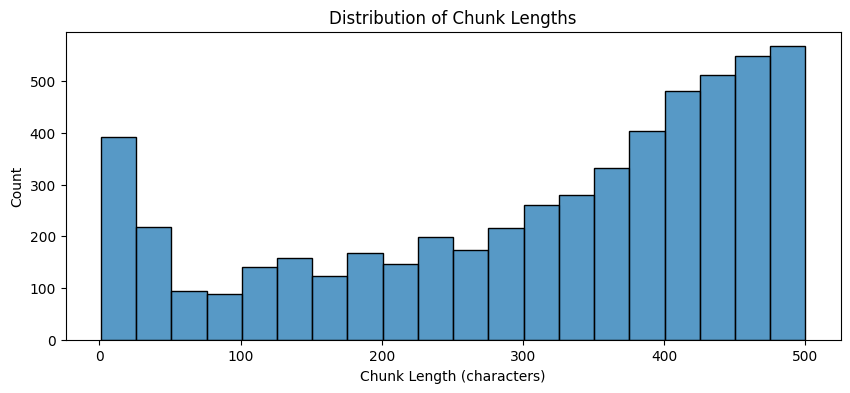

In [13]:
# Process documents with chunking
def process_documents(documents):
    """
    Process documents with RecursiveCharacterTextSplitter
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks")
    return chunks

# Initialize the embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
print(f"Initialized embedding model: {embedding_model.model_name}")

# Process our documents with the splitter
processed_docs = process_documents(documents)
print(f"First processed chunk: {processed_docs[0].page_content[:100]}...")

# Display some statistics about chunk lengths
chunk_lengths = [len(doc.page_content) for doc in processed_docs]
print(f"\nChunk statistics:")
print(f"- Average chunk length: {sum(chunk_lengths) / len(chunk_lengths):.2f} characters")
print(f"- Min chunk length: {min(chunk_lengths)} characters")
print(f"- Max chunk length: {max(chunk_lengths)} characters")

# Plot distribution of chunk lengths
plt.figure(figsize=(10, 4))
sns.histplot(chunk_lengths, bins=20)
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Chunk Length (characters)')
plt.ylabel('Count')
plt.show()

### 4.3 Vector Store Setup

In [15]:
# Initialize Chroma vector store
def initialize_vectorstore(documents, embedding_model):
    """
    Initialize Chroma vector store with documents
    """
    # Setup persistent client for Chroma
    import chromadb
    from chromadb.config import Settings
    
    # Create the persistence directory if it doesn't exist
    import os
    os.makedirs("./chroma_db", exist_ok=True)
    
    # Initialize the client with persistence
    client = chromadb.PersistentClient(
        path="./chroma_db",
        settings=Settings(
            anonymized_telemetry=False,
            allow_reset=True
        )
    )
    
    # Create a new collection or get existing one
    try:
        client.delete_collection("wiki_collection")
        print("Deleted existing collection")
    except:
        print("No existing collection to delete")
    
    # Initialize Chroma with the client
    vectorstore = Chroma(
        client=client,
        collection_name="wiki_collection",
        embedding_function=embedding_model,
    )
    
    # Add documents
    batch_size = 5000  # Keep under Chroma's max batch size
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]
        vectorstore.add_documents(batch)
        print(f"Added batch {i//batch_size + 1} containing {len(batch)} documents")

    print(f"Added {len(documents)} documents to vector store")
    
    return vectorstore

# Create the vector store with our processed documents
vectorstore = initialize_vectorstore(processed_docs, embedding_model)

# Test the retriever with a sample query
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
test_query = questions[0]
retrieved_docs = retriever.invoke(test_query)

print(f"\nTest query: {test_query}")
print(f"Retrieved {len(retrieved_docs)} documents")
for i, doc in enumerate(retrieved_docs):
    print(f"\nDocument {i+1}:")
    print(f"Source: {doc.metadata.get('source', 'Unknown')}")
    print(f"Content: {doc.page_content[:150]}...")

Deleted existing collection
Added batch 1 containing 5000 documents
Added batch 2 containing 497 documents
Added 5497 documents to vector store


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Test query: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Retrieved 3 documents

Document 1:
Source: sample_0_context_0
Content: . As such, US and foreign born Sub-Saharan Africans are distinct from native-born African Americans, many of whose ancestors were involuntarily brough...

Document 2:
Source: sample_0_context_0
Content: African immigration to the United States refers to immigrants to the United States who are or were nationals of modern African countries. The term Afr...

Document 3:
Source: sample_0_context_0
Content: The influx of African immigrants began in the latter part of the 20th century and is often referred to as the "fourth great migration." About three-fo...


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 

### 4.4 Simple RAG Implementation

In [19]:
class SimpleRAG:
    """
    Basic RAG implementation with a linear retrieve-then-generate pipeline.
    """
    def __init__(self, retriever, llm):
        self.retriever = retriever
        self.llm = llm
        
        # Create a simple prompt template for RAG
        self.prompt = ChatPromptTemplate.from_template(
            """Answer the following question based only on the provided context:  
            
            Context: {context}
            
            Question: {question}
            
            Answer:"""
        )
        
        # Create the RAG chain
        self.rag_chain = (
            {"context": self.retriever, "question": RunnablePassthrough()}
            | self.prompt
            | self.llm
            | StrOutputParser()
        )
    
    def invoke(self, query):
        """
        Process a query through the RAG system
        
        Args:
            query: The user question as a string
            
        Returns:
            dict: A dictionary containing the answer and retrieved context
        """
        # For evaluation purposes, we'll return both the answer and the retrieved documents
        retrieved_docs = self.retriever.invoke(query)
        answer = self.rag_chain.invoke(query)
        
        return {
            "answer": answer,
            "context": retrieved_docs
        }

# Initialize a language model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Create our Simple RAG system
simple_rag = SimpleRAG(retriever, llm)

# Test with a sample query
test_result = simple_rag.invoke(test_query)
print(f"\nSimple RAG Test:")
print(f"Query: {test_query}")
print(f"Answer: {test_result['answer']}")


Simple RAG Test:
Query: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Answer: African Americans were not immigrants to the United States; many of their ancestors were involuntarily brought from West and Central Africa to the colonial United States through the historic Atlantic slave trade. This forced migration occurred long before the modern immigration patterns of African nationals.


### 4.5 CRAG Implementation

In [20]:
from pydantic import BaseModel, Field
from typing import Literal

# Define a structured output class for document grading
class DocumentRelevanceCheck(BaseModel):
    """Assessment of document relevance to the question."""
    is_relevant: bool = Field(description="Whether the document is relevant to the question")
    reasoning: str = Field(description="Explanation of the relevance assessment")

# Define a class for routing decisions
class SearchDecision(BaseModel):
    """Decision on whether to use web search."""
    use_web_search: bool = Field(description="Whether to use web search")
    reasoning: str = Field(description="Explanation for the decision")

class CRAG:
    """
    Corrective RAG (CRAG) implementation with document relevance checking and web search fallback.
    """
    def __init__(self, retriever, llm, web_search_tool=None):
        self.retriever = retriever
        self.llm = llm
        self.web_search_tool = web_search_tool
        
        # Create the LLM for structured outputs
        self.structured_llm = llm.with_structured_output(DocumentRelevanceCheck)
        self.decision_llm = llm.with_structured_output(SearchDecision)
        
        # Create the document grader prompt
        self.grade_prompt = ChatPromptTemplate.from_template(
            """Assess whether the following document is relevant to answering the question.
            
            Question: {question}
            
            Document: {document}
            
            Provide a boolean indicating if the document is relevant and explain your reasoning."""
        )
        
        # Create the search decision prompt
        self.search_decision_prompt = ChatPromptTemplate.from_template(
            """Based on the retrieved documents and the question, decide if a web search is needed.
            
            Question: {question}
            
            Retrieved documents: {documents}
            
            Number of relevant documents: {num_relevant}
            
            Should we use web search to get better information? Provide a boolean decision and explain your reasoning."""
        )
        
        # Create the generation prompt
        self.generate_prompt = ChatPromptTemplate.from_template(
            """Answer the following question based on the provided context. 
            If the context doesn't contain enough information to provide a complete answer, say so.
            
            Context: {context}
            
            Question: {question}
            
            Answer:"""
        )
        
        # Create the query rewriting prompt for web search
        self.query_rewrite_prompt = ChatPromptTemplate.from_template(
            """Rewrite the following question to make it more effective for a web search. 
            Remove any personal context, clarify any ambiguous terms, and focus on the core information need.
            
            Original Question: {question}
            
            Rewritten Search Query:"""
        )
        
        # Create the chains for document grading, web search, and generation
        self.grader_chain = self.grade_prompt | self.structured_llm
        self.decision_chain = self.search_decision_prompt | self.decision_llm
        self.query_rewrite_chain = self.query_rewrite_prompt | self.llm | StrOutputParser()
        self.generate_chain = self.generate_prompt | self.llm | StrOutputParser()
    
    def invoke(self, query):
        """
        Process a query through the CRAG system
        
        Args:
            query: The user question as a string
            
        Returns:
            dict: A dictionary containing the answer and retrieved context
        """
        print(f"\nProcessing query: {query}")
        
        # Step 1: Retrieve initial documents
        retrieved_docs = self.retriever.invoke(query)
        print(f"Retrieved {len(retrieved_docs)} documents from vector store")
        
        # Step 2: Grade each document for relevance
        relevant_docs = []
        for doc in retrieved_docs:
            try:
                assessment = self.grader_chain.invoke({
                    "question": query, 
                    "document": doc.page_content
                })
                
                if assessment.is_relevant:
                    print(f"✅ Document {retrieved_docs.index(doc) + 1} is relevant")
                    relevant_docs.append(doc)
                else:
                    print(f"❌ Document {retrieved_docs.index(doc) + 1} is not relevant")
            except Exception as e:
                print(f"Error grading document: {e}")
        
        # Step 3: Decide if web search is needed
        if self.web_search_tool and len(relevant_docs) < 2:  # If we have fewer than 2 relevant docs
            try:
                decision = self.decision_chain.invoke({
                    "question": query,
                    "documents": "\n\n".join([doc.page_content for doc in retrieved_docs]),
                    "num_relevant": len(relevant_docs)
                })
                
                if decision.use_web_search:
                    print(f"🔎 Decided to use web search: {decision.reasoning}")
                    
                    # Rewrite the query for better web search results
                    search_query = self.query_rewrite_chain.invoke({"question": query})
                    print(f"Rewritten search query: {search_query}")
                    
                    # Perform web search
                    search_results = self.web_search_tool.invoke({"query": search_query})
                    print(f"Found {len(search_results)} results from web search")
                    
                    # Convert search results to documents
                    web_docs = []
                    for result in search_results:
                        web_docs.append(Document(
                            page_content=result["content"],
                            metadata={"source": result["url"], "title": result.get("title", "Unknown")}
                        ))
                    
                    # Combine relevant docs with web search results
                    final_docs = relevant_docs + web_docs
                else:
                    print(f"🔍 Decided NOT to use web search: {decision.reasoning}")
                    final_docs = relevant_docs
            except Exception as e:
                print(f"Error in search decision: {e}")
                final_docs = relevant_docs
        else:
            final_docs = relevant_docs
            
        # If we have no relevant docs, fall back to the original retrieved docs
        if len(final_docs) == 0:
            print("⚠️ No relevant documents found, falling back to original retrieved documents")
            final_docs = retrieved_docs
            
        # Step 4: Generate the answer
        context_text = "\n\n".join([doc.page_content for doc in final_docs])
        answer = self.generate_chain.invoke({
            "context": context_text, 
            "question": query
        })
        
        return {
            "answer": answer,
            "context": final_docs
        }

# Initialize the web search tool (if TAVILY_API_KEY is set)
web_search_tool = None
try:
    if os.environ.get("TAVILY_API_KEY"):
        web_search_tool = TavilySearchResults(k=3)
        print("Initialized Tavily web search tool")
    else:
        print("Tavily API key not set, web search functionality disabled")
except Exception as e:
    print(f"Error initializing web search tool: {e}")

# Create the CRAG system
crag = CRAG(retriever, llm, web_search_tool)

# Test with a sample query
test_result_crag = crag.invoke(test_query)
print(f"\nCRAG Test:")
print(f"Query: {test_query}")
print(f"Answer: {test_result_crag['answer']}")
print(f"Used {len(test_result_crag['context'])} documents for generating the answer")

Initialized Tavily web search tool

Processing query: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Retrieved 3 documents from vector store
✅ Document 1 is relevant
❌ Document 2 is not relevant
❌ Document 3 is not relevant
🔍 Decided NOT to use web search: The retrieved documents provide a clear overview of the immigration of African Americans to the U.S., distinguishing between the historical context of involuntary migration through the slave trade and the more recent voluntary immigration of Sub-Saharan Africans. The information covers key aspects such as the timeline of immigration, reasons for migration, and demographic changes, which sufficiently addresses the question without the need for additional web search.

CRAG Test:
Query: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Answer: African Americans were not immigrants to the US; rather, many of their ancestors were involuntarily brought to the United States from West and Central Africa through the historic Atlantic slave tra

### 4.6 Adaptive RAG Implementation

In [22]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any, Literal

# Define structured output for query classification
class QueryClassification(BaseModel):
    """Classification of query type for routing."""
    query_type: Literal["simple_factual", "complex_relational", "current_event", "beyond_knowledge"] = \
        Field(description="The type of the query")
    reasoning: str = Field(description="Explanation for the classification")

# Define state for our LangGraph
class AdaptiveRAGState(TypedDict):
    """State for Adaptive RAG workflow."""
    question: str
    query_type: str
    context: List[Document]
    answer: str

class AdaptiveRAG:
    """
    Adaptive RAG implementation with routing based on query type.
    """
    def __init__(self, retriever, llm, web_search_tool=None):
        self.retriever = retriever
        self.llm = llm
        self.web_search_tool = web_search_tool
        
        # Create the LLM for structured outputs
        self.classifier_llm = llm.with_structured_output(QueryClassification)
        
        # Create the classifier prompt
        self.classifier_prompt = ChatPromptTemplate.from_template(
            """Classify the following question into one of these categories:
            
            - simple_factual: Straightforward factual questions that can be answered with basic information
            - complex_relational: Questions requiring understanding relationships between multiple entities
            - current_event: Questions about recent events, news, or time-sensitive information
            - beyond_knowledge: Questions beyond the scope of your knowledge base
            
            Question: {question}
            
            Provide your classification and explain your reasoning."""
        )
        
        # Create the generation prompt
        self.generate_prompt = ChatPromptTemplate.from_template(
            """Answer the following question based on the provided context. 
            If the context doesn't contain enough information to provide a complete answer, say so.
            
            Context: {context}
            
            Question: {question}
            
            Answer:"""
        )
        
        # Define LangGraph nodes
        self.workflow = self._build_workflow()
        
        # Create chains
        self.classifier_chain = self.classifier_prompt | self.classifier_llm
        self.generate_chain = self.generate_prompt | self.llm | StrOutputParser()
        
    def _build_workflow(self):
        # Node functions
        def classify_query(state: AdaptiveRAGState) -> AdaptiveRAGState:
            question = state["question"]
            
            classification = self.classifier_chain.invoke({"question": question})
            
            return {"query_type": classification.query_type}
        
        def route_query(state: AdaptiveRAGState) -> Literal["simple_retrieval", "web_search", "direct_generation"]:
            query_type = state["query_type"]
            
            if query_type in ["simple_factual", "complex_relational"]:
                return "simple_retrieval"
            elif query_type in ["current_event"]:
                return "web_search"
            else:  # beyond_knowledge
                return "direct_generation"
        
        def simple_retrieval(state: AdaptiveRAGState) -> AdaptiveRAGState:
            question = state["question"]
            context = self.retriever.invoke(question)
            return {"context": context}
        
        def web_search(state: AdaptiveRAGState) -> AdaptiveRAGState:
            if not self.web_search_tool:
                # Fall back to retrieval if web search is not available
                print("⚠️ Web search tool not available, falling back to retrieval")
                return simple_retrieval(state)
            
            question = state["question"]
            try:
                search_results = self.web_search_tool.invoke({"query": question})
                
                # Convert search results to documents
                web_docs = []
                for result in search_results:
                    web_docs.append(Document(
                        page_content=result["content"],
                        metadata={"source": result["url"], "title": result.get("title", "Unknown")}
                    ))
                
                return {"context": web_docs}
            except Exception as e:
                print(f"⚠️ Web search error: {e}, falling back to retrieval")
                return simple_retrieval(state)
        
        def direct_generation(state: AdaptiveRAGState) -> AdaptiveRAGState:
            # When we don't need retrieval, we'll provide an empty context
            return {"context": []}
        
        def generate_answer(state: AdaptiveRAGState) -> AdaptiveRAGState:
            question = state["question"]
            context = state["context"]
            
            if len(context) > 0:
                context_text = "\n\n".join([doc.page_content for doc in context])
                answer = self.generate_chain.invoke({
                    "context": context_text, 
                    "question": question
                })
            else:
                # Direct generation without context for beyond_knowledge queries
                answer = self.llm.invoke([
                    ("system", "You are a helpful assistant. If you don't know the answer, say so."),
                    ("human", question)
                ]).content
                
            return {"answer": answer}
        
        # Build the graph
        workflow = StateGraph(AdaptiveRAGState)
        
        # Add nodes
        workflow.add_node("classify", classify_query)
        workflow.add_node("simple_retrieval", simple_retrieval)
        workflow.add_node("web_search", web_search)
        workflow.add_node("direct_generation", direct_generation)
        workflow.add_node("generate", generate_answer)
        

        workflow.add_conditional_edges(
            "classify",
            route_query,
            {
                "simple_retrieval": "simple_retrieval",
                "web_search": "web_search",
                "direct_generation": "direct_generation"
            }
        )
        
        # Add remaining edges
        workflow.add_edge("simple_retrieval", "generate")
        workflow.add_edge("web_search", "generate")
        workflow.add_edge("direct_generation", "generate")
        workflow.add_edge("generate", END)
        
        # Set entry point
        workflow.set_entry_point("classify")
        
        return workflow.compile()
    
    def invoke(self, query):
        """
        Process a query through the Adaptive RAG system
        
        Args:
            query: The user question as a string
            
        Returns:
            dict: A dictionary containing the answer and retrieved context
        """
        print(f"\nProcessing query through Adaptive RAG: {query}")
        
        # Run the workflow
        result = self.workflow.invoke({"question": query})
        
        return {
            "answer": result["answer"],
            "context": result["context"] if "context" in result else []
        }

# Create the Adaptive RAG system
adaptive_rag = AdaptiveRAG(retriever, llm, web_search_tool)

# Test with a sample query
test_result_adaptive = adaptive_rag.invoke(test_query)
print(f"\nAdaptive RAG Test:")
print(f"Query: {test_query}")
print(f"Answer: {test_result_adaptive['answer']}")
print(f"Used {len(test_result_adaptive['context'])} documents for generating the answer")

# Use a different sample query that might trigger web search
if len(questions) > 5:
    alt_query = questions[5]  # Try a different question
    print(f"\nTesting with alternative query: {alt_query}")
    alt_result_adaptive = adaptive_rag.invoke(alt_query)
    print(f"Answer: {alt_result_adaptive['answer']}")
    print(f"Used {len(alt_result_adaptive['context'])} documents for generating the answer")


Processing query through Adaptive RAG: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US

Adaptive RAG Test:
Query: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Answer: The context does not provide information on how African Americans immigrated to the United States. It specifically discusses the distinct history of Sub-Saharan African immigrants and their migration patterns, particularly in relation to the Atlantic slave trade and the growth of the Black population in New York City. Therefore, I cannot provide a complete answer to the question.
Used 3 documents for generating the answer

Testing with alternative query: what is a notary for

Processing query through Adaptive RAG: what is a notary for
Answer: A notary serves as a public officer to validate signatures, administer oaths, take affidavits and statutory declarations, authenticate document executions, take acknowledgments, provide notice of foreign drafts, and perform other official acts, primarily in non-contentious matter

In [25]:
# Create the evaluation dataset from our samples
def prepare_evaluation_dataset(system, samples, num_samples=10):
    """
    Prepare evaluation dataset for RAGAS
    
    Args:
        system: RAG system to evaluate
        samples: List of question-answer pairs
        num_samples: Number of samples to evaluate (limit to avoid excessive API calls)
    
    Returns:
        EvaluationDataset: RAGAS evaluation dataset
    """
    # Limit the number of samples to evaluate
    evaluation_subset = samples[:num_samples]
    
    # Process each sample through the RAG system
    eval_data = []
    for sample in evaluation_subset:
        question = sample["user_input"]
        
        # Process with the RAG system
        result = system.invoke(question)
        
        # Construct the evaluation sample
        eval_data.append({
            "user_input": question,
            "reference": sample["reference"],
            "response": result["answer"],
            "retrieved_contexts": [doc.page_content for doc in result["context"]]
        })
    
    # Create RAGAS evaluation dataset
    return EvaluationDataset.from_list(eval_data)

# Initialize the evaluator LLM
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini", temperature=0))

# Define evaluation metrics
metrics = [
    Faithfulness(llm=evaluator_llm),
    ContextPrecision(llm=evaluator_llm),
    ContextRecall(llm=evaluator_llm),
    AnswerRelevancy(llm=evaluator_llm),
    AnswerCorrectness(llm=evaluator_llm)
]

# Evaluate each RAG system
def evaluate_system(system, name):
    """
    Evaluate a RAG system using RAGAS metrics
    
    Args:
        system: The RAG system to evaluate
        name: Name of the system for reporting
        
    Returns:
        dict: Evaluation results
    """
    print(f"\nEvaluating {name}...")
    
    # Prepare dataset
    eval_dataset = prepare_evaluation_dataset(system, evaluation_samples)
    
    # Run evaluation
    results = evaluate(
        dataset=eval_dataset,
        metrics=metrics,
        llm=evaluator_llm
    )
    
    print(f"\n{name} Evaluation Results:")
    for metric_name, score in results._repr_dict.items():
        print(f"- {metric_name}: {score:.4f}")
    
    return {
        "name": name,
        "results": results._repr_dict,
        "details": results
    }

# Evaluate all systems
all_results = []
systems = [
    (simple_rag, "Simple RAG"),
    (crag, "Corrective RAG (CRAG)"),
    (adaptive_rag, "Adaptive RAG")
]

for system, name in systems:
    result = evaluate_system(system, name)
    all_results.append(result)

# Get individual dataframes for detailed analysis
system_dfs = []
for result in all_results:
    df = result["details"].to_pandas()
    df["system"] = result["name"]
    system_dfs.append(df)
    
# Create a combined dataframe for analysis
combined_df = pd.concat(system_dfs, ignore_index=True)
print(f"\nCombined evaluation dataset shape: {combined_df.shape}")


Evaluating Simple RAG...


Evaluating: 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]



Simple RAG Evaluation Results:
- faithfulness: 0.9375
- context_precision: 0.8083
- context_recall: 0.9000
- answer_relevancy: 0.8882
- answer_correctness: 0.5190

Evaluating Corrective RAG (CRAG)...

Processing query: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US
Retrieved 3 documents from vector store
✅ Document 1 is relevant
❌ Document 2 is not relevant
❌ Document 3 is not relevant
🔍 Decided NOT to use web search: The retrieved documents provide sufficient information regarding the immigration of African Americans to the U.S., particularly the distinction between native-born African Americans and African immigrants. They cover the historical context of the Atlantic slave trade and the more recent trends in African immigration, which are relevant to the question. Therefore, a web search is not necessary.

Processing query: what are points on a mortgage
Retrieved 3 documents from vector store
✅ Document 1 is relevant
✅ Document 2 is relevant
✅ Document 3 is relevant

Processing que

Evaluating: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]



Corrective RAG (CRAG) Evaluation Results:
- faithfulness: 0.9457
- context_precision: 0.8417
- context_recall: 0.8000
- answer_relevancy: 0.9073
- answer_correctness: 0.6136

Evaluating Adaptive RAG...

Processing query through Adaptive RAG: HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US

Processing query through Adaptive RAG: what are points on a mortgage

Processing query through Adaptive RAG: how does interlibrary loan work

Processing query through Adaptive RAG: WHAT IS A FY QUARTER

Processing query through Adaptive RAG: who wrote a rose is a rose is a rose

Processing query through Adaptive RAG: what is a notary for

Processing query through Adaptive RAG: what bacteria grow on macconkey agar

Processing query through Adaptive RAG: who played the lead roles in the movie leaving las vegas

Processing query through Adaptive RAG: what is a CMM machine

Processing query through Adaptive RAG: what percentage of water in in the body


Evaluating: 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]



Adaptive RAG Evaluation Results:
- faithfulness: 0.8700
- context_precision: 0.8083
- context_recall: 0.8000
- answer_relevancy: 0.8042
- answer_correctness: 0.5807

Combined evaluation dataset shape: (30, 10)


## 6. Results Visualization

Generating bar chart comparison...


<Figure size 640x480 with 0 Axes>

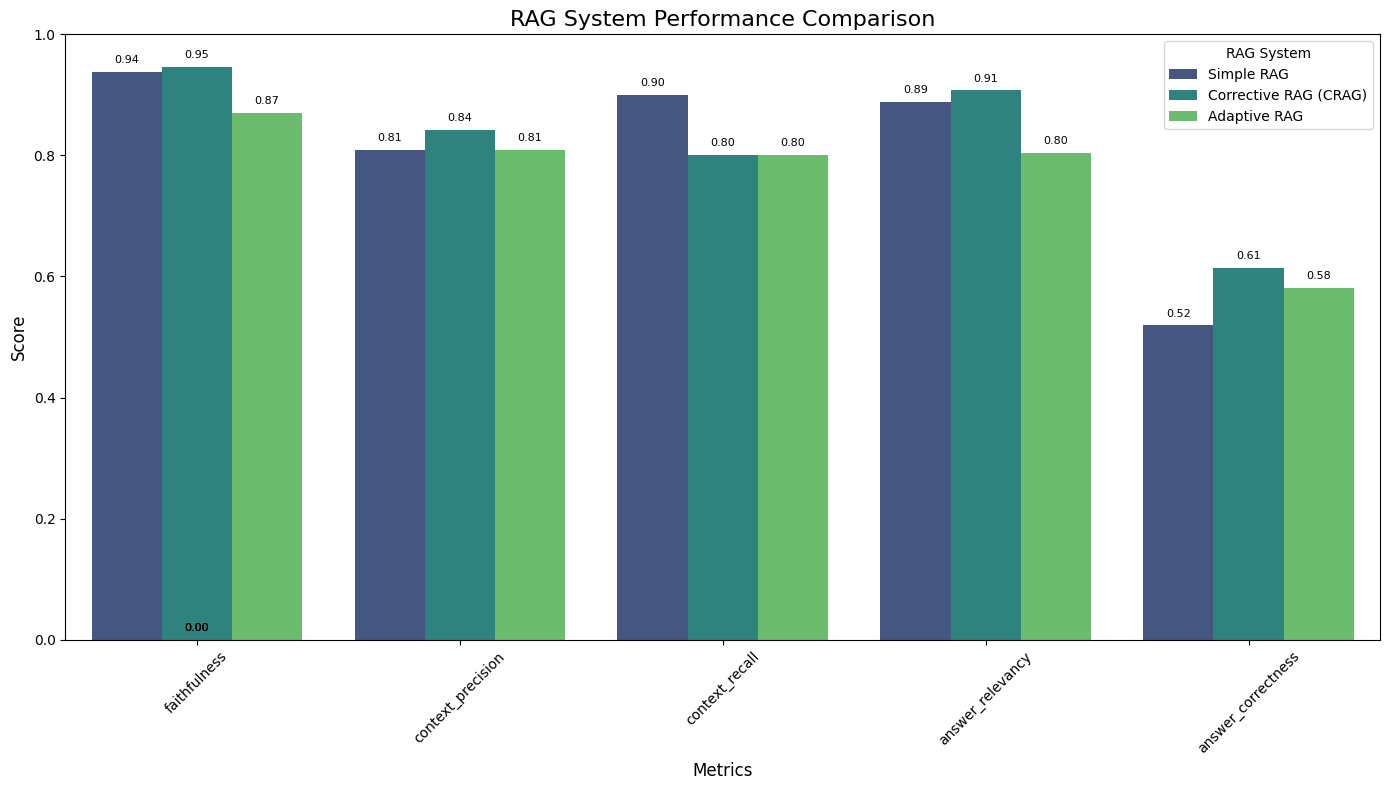


Generating radar chart...


<Figure size 640x480 with 0 Axes>

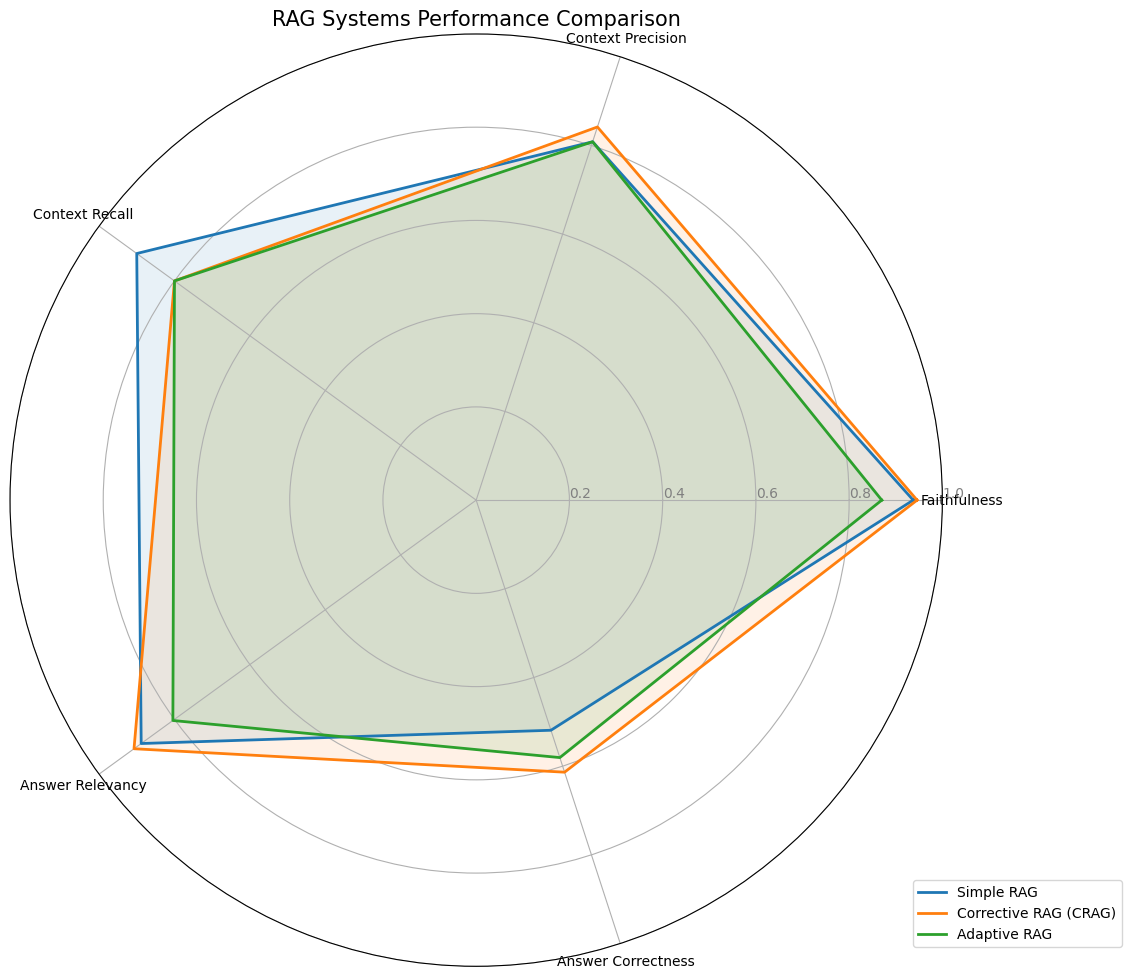


Generating performance heatmap...


<Figure size 640x480 with 0 Axes>

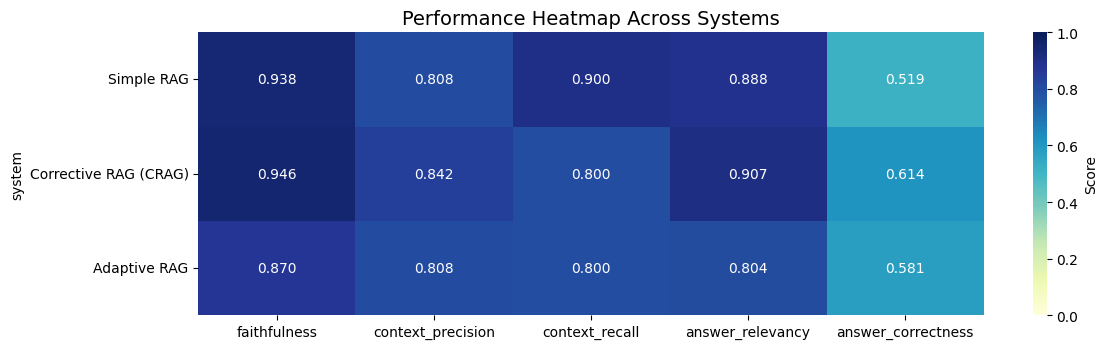


Calculating and displaying overall scores...


/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/ipykernel_50483/3544573011.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(


<Figure size 640x480 with 0 Axes>

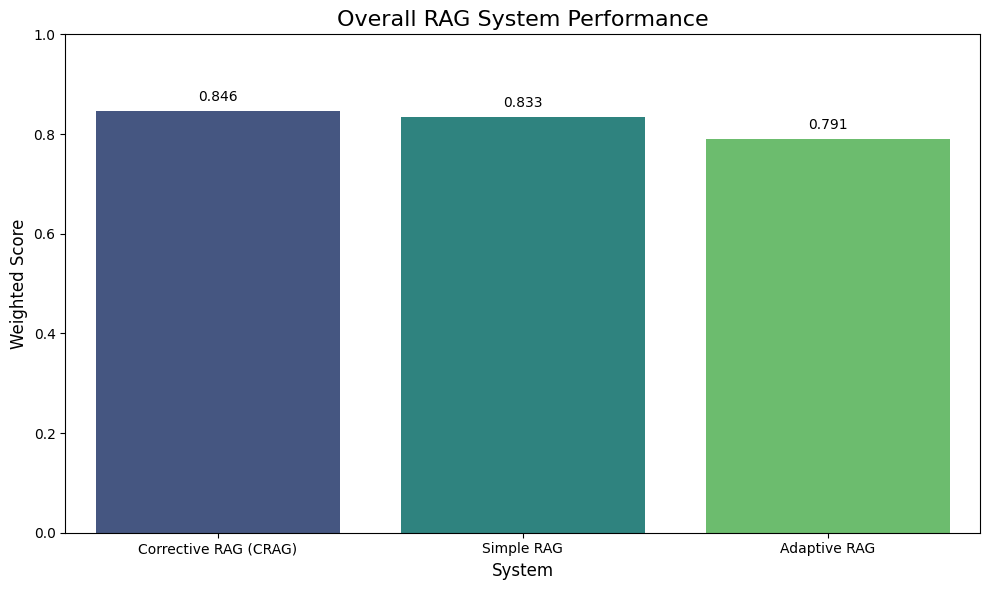


Overall System Rankings:
                  System  Overall Score
1  Corrective RAG (CRAG)       0.845537
0             Simple RAG       0.833414
2           Adaptive RAG       0.790607


/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/ipykernel_50483/3544573011.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(


<Figure size 640x480 with 0 Axes>

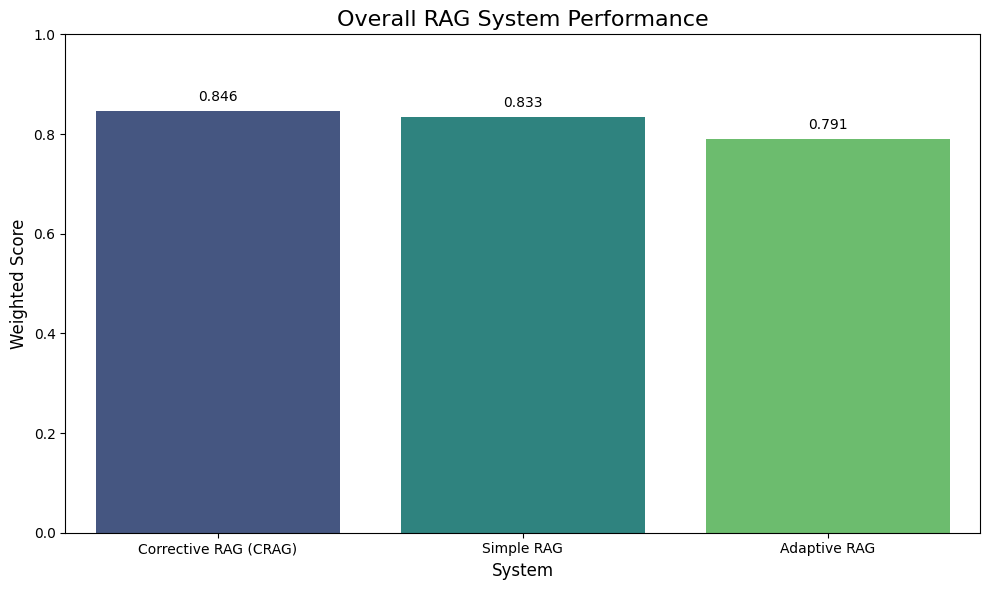


Overall System Rankings:
                  System  Overall Score
1  Corrective RAG (CRAG)       0.845537
0             Simple RAG       0.833414
2           Adaptive RAG       0.790607


In [28]:
# Visualize the evaluation results
# Complete visualization code with fixes for empty plots and white boxes

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Visualization functions with fixes
def create_metric_comparison_chart(all_results):
    """
    Create a bar chart comparing metrics across systems
    
    Args:
        all_results: List of evaluation results
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Prepare data
    systems = [r["name"] for r in all_results]
    metrics = list(all_results[0]["results"].keys())
    
    # Create a DataFrame for plotting
    plot_data = []
    for system_result in all_results:
        for metric, value in system_result["results"].items():
            plot_data.append({
                "System": system_result["name"],
                "Metric": metric,
                "Score": value
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Clear any previous plots
    plt.clf()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # For newer seaborn versions (>=0.12.0)
    try:
        chart = sns.barplot(
            data=plot_df,
            x="Metric",
            y="Score",
            hue="System",
            palette="viridis",
            errorbar=None,
            ax=ax
        )
    except TypeError:  # Fall back to older API for older seaborn versions
        chart = sns.barplot(
            data=plot_df,
            x="Metric",
            y="Score",
            hue="System",
            palette="viridis",
            ax=ax
        )
    
    # Add labels and title
    plt.title("RAG System Performance Comparison", fontsize=16)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.0)  # Consistent y-axis limit
    plt.legend(title="RAG System", fontsize=10)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    # Add score values on top of bars
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=0,
            xytext=(0, 5),
            textcoords="offset points"
        )
    
    plt.tight_layout()
    plt.show()
    return fig

def create_radar_chart(all_results):
    """
    Create a radar chart showing the strengths of each system
    
    Args:
        all_results: List of evaluation results
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Prepare data
    systems = [r["name"] for r in all_results]
    metrics = list(all_results[0]["results"].keys())
    
    # Convert metric names to more readable format
    readable_metrics = [metric.replace("_", " ").title() for metric in metrics]
    
    # Convert to scores array
    scores = np.zeros((len(systems), len(metrics)))
    for i, system_result in enumerate(all_results):
        for j, metric in enumerate(metrics):
            scores[i, j] = system_result["results"][metric]
    
    # Clear any previous plots
    plt.clf()
    
    # Create radar chart
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    
    # Create the figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, polar=True)
    
    # Add the first angle again at the end to close the loop
    angles = np.append(angles, angles[0])
    
    # Add the first metric name again to close the labels
    readable_metrics.append(readable_metrics[0])
    
    # Plot each system with loop closure
    for i, system in enumerate(systems):
        values = scores[i].tolist()
        # Add the first value again to close the loop
        values.append(values[0])
        ax.plot(angles, values, linewidth=2, label=system)
        ax.fill(angles, values, alpha=0.1)
    
    # Add labels and configure the chart
    ax.set_thetagrids(np.degrees(angles[:-1]), readable_metrics[:-1])
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(0)  # Move radial labels to better position
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey")
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.1))
    
    plt.title("RAG Systems Performance Comparison", size=15)
    plt.tight_layout()
    plt.show()
    return fig

def create_performance_heatmap(combined_df, systems):
    """
    Create a heatmap showing performance per query across systems
    
    Args:
        combined_df: Combined dataframe from evaluation results
        systems: List of system names
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Get the metrics (excluding data columns)
    metric_cols = [col for col in combined_df.columns if col not in [
        "user_input", "response", "retrieved_contexts", "reference", "system"
    ]]
    
    if not metric_cols:
        print("No metric columns found. Available columns:", combined_df.columns)
        return None
    
    # Group by system and calculate mean scores for each metric
    heatmap_data = combined_df.groupby("system")[metric_cols].mean()
    
    # Sort the index to match the order in systems list
    system_names = [s[1] for s in systems]  # Extract system names
    heatmap_data = heatmap_data.reindex(system_names)
    
    # Clear any previous plots
    plt.clf()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, len(systems) * 1.2))
    heatmap = sns.heatmap(
        heatmap_data,
        annot=True,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        fmt=".3f",
        cbar_kws={"label": "Score"},
        ax=ax
    )
    
    plt.title("Performance Heatmap Across Systems", fontsize=14)
    plt.tight_layout()
    plt.show()
    return fig

def calculate_overall_scores(all_results):
    """
    Calculate weighted average scores for each system
    """
    # Define metric weights (can be adjusted based on importance)
    weights = {
        "faithfulness": 0.3,
        "context_precision": 0.2,
        "context_recall": 0.15,
        "answer_relevancy": 0.2,
        "answer_correctness": 0.15
    }
    
    overall_scores = []
    for result in all_results:
        weighted_sum = 0
        for metric, score in result["results"].items():
            # Match metric name to weight key (handling suffix like 'mode=f1')
            for weight_key in weights:
                if weight_key in metric:
                    weighted_sum += score * weights[weight_key]
                    break
        
        overall_scores.append({
            "System": result["name"],
            "Overall Score": weighted_sum
        })
    
    # Create dataframe and sort by score
    scores_df = pd.DataFrame(overall_scores).sort_values("Overall Score", ascending=False)
    
    # Clear any previous plots
    plt.clf()
    
    # Plot overall scores
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # For newer seaborn versions (>=0.12.0)
    try:
        chart = sns.barplot(
            x="System", 
            y="Overall Score", 
            data=scores_df, 
            palette="viridis",
            errorbar=None,
            ax=ax
        )
    except TypeError:  # Fall back to older API
        chart = sns.barplot(
            x="System", 
            y="Overall Score", 
            data=scores_df, 
            palette="viridis",
            ax=ax
        )
    
    # Add labels
    plt.title("Overall RAG System Performance", fontsize=16)
    plt.xlabel("System", fontsize=12)
    plt.ylabel("Weighted Score", fontsize=12)
    plt.ylim(0, 1.0)
    
    # Add score values on top of bars
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.3f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
            xytext=(0, 5),
            textcoords="offset points"
        )
    
    plt.tight_layout()
    plt.show()
    
    return scores_df

def visualize_all_results(all_results, combined_df):
    """
    Run all visualizations separately to avoid subplot issues
    """
    print("Generating bar chart comparison...")
    create_metric_comparison_chart(all_results)
    
    print("\nGenerating radar chart...")
    create_radar_chart(all_results)
    
    print("\nGenerating performance heatmap...")
    systems = [(i, r["name"]) for i, r in enumerate(all_results)]
    create_performance_heatmap(combined_df, systems)
    
    print("\nCalculating and displaying overall scores...")
    overall_scores = calculate_overall_scores(all_results)
    print("\nOverall System Rankings:")
    print(overall_scores)

# Example usage:
visualize_all_results(all_results, combined_df)
# create_dashboard(all_results, combined_df)

# Calculate and display overall scores
overall_scores = calculate_overall_scores(all_results)
print("\nOverall System Rankings:")
print(overall_scores)

## 7. Conclusion and Best Practices

### Key Findings

In this notebook, we've explored three different RAG architectures - Simple RAG, Corrective RAG (CRAG), and Adaptive RAG - and evaluated their performance using the RAGAS framework. Our evaluation provides several key insights:

1. **Architectural Tradeoffs**: Each RAG architecture offers different tradeoffs in terms of complexity, performance, and resource usage. Simple RAG provides a straightforward implementation but lacks robustness, while CRAG and Adaptive RAG offer more sophisticated approaches with better handling of edge cases.

2. **Context Quality Matters**: The evaluation demonstrates that document relevance assessment is crucial for high-quality responses. Systems that filter and validate retrieved content (like CRAG) tend to perform better on faithfulness and context precision metrics.

3. **Adaptive Routing**: The ability to route queries through different processing paths based on query analysis (as in Adaptive RAG) shows promise for addressing diverse information needs efficiently.

4. **System Strengths**: Each architecture showed unique strengths:
   - Simple RAG: Efficiency and simplicity for straightforward queries
   - CRAG: Improved response quality through document validation
   - Adaptive RAG: Resource optimization and flexibility across query types

### Best Practices for RAG Implementation

1. **Document Processing**:
   - Use appropriate chunking strategies based on your content type
   - Ensure chunks contain complete semantic units when possible
   - Include sufficient context overlap between adjacent chunks

2. **Embedding Selection**:
   - Choose embedding models aligned with your domain and language
   - Consider the tradeoff between model size and performance
   - Periodically re-evaluate embedding quality as new models become available

3. **Retrieval Optimization**:
   - Experiment with different similarity metrics (cosine, dot product, etc.)
   - Explore hybrid retrieval combining semantic and keyword search
   - Implement re-ranking to improve relevance of top results

4. **Prompting Strategy**:
   - Design clear, consistent prompts that specify how retrieved context should be used
   - Provide explicit instructions for handling ambiguity or insufficient information
   - Consider few-shot examples for complex reasoning tasks

5. **Monitoring and Evaluation**:
   - Regularly evaluate system performance with diverse test sets
   - Track metrics over time to detect performance degradation
   - Include human evaluation alongside automated metrics

### Future Directions

The field of retrieval-augmented generation continues to evolve rapidly. Some promising directions for further improvement include:

1. **Multi-stage Retrieval**: Implementing sequential retrieval steps to handle complex queries requiring information synthesis

2. **Memory Integration**: Combining knowledge retrieval with conversation history for more contextual responses

3. **Self-reflective Capabilities**: Enabling systems to critique and improve their own outputs through feedback loops

4. **Multimodal Retrieval**: Extending RAG beyond text to include images, audio, and other data types

5. **Fine-grained Evaluation**: Developing more specialized metrics for specific RAG use cases and failure modes

By implementing these best practices and staying aware of emerging research, you can build high-performance RAG systems that provide accurate, relevant, and helpful responses to user queries.
